# Simulate LSST cadence and error curve 

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
import celerite
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

### LSST cadence 

In [5]:
# add LSST epochs 
# spanning 2023 - 2032 : 
# 10 years, 50 epochs per year ...

# pick random 50 from 365 days without repetition,
# then pick the decimal part of date picking eg.  
# between 0 - 0.4 per night ...

from astropy.time import Time
start_date = Time(['2023-01-01T00:00:00.000'],format='isot')#, scale='utc')
# haha, weird warning : here is a discussion about it 
# https://github.com/astropy/astropy/blob/ffc0a89b2c42fd440eb19bcb2f93db90cab3c98b/cextern/erfa/dat.c#L64 

# apparently 2023 is too far into the future to reliably predict leap second ... 
# but the error message could be improved upon - this one is very vague! 

mjd_lsst  = []
N_py = 50 # Number of points per year  
for i in range(2033-2023): # 2023 to 2033 : ten full years .... 
    days = np.random.choice(np.arange(365), size=N_py, replace=False)
    hours = np.random.choice(np.linspace(0,0.4,1000), size=N_py, replace=False)
    yearly_obs = start_date.mjd[0] + days + i*365 + hours 
    mjd_lsst.append(yearly_obs)
mjd_lsst = np.sort(np.concatenate(mjd_lsst))
# save for reference : these are the  time stamps 
# I use for LSST 

# I hope that the stochasticity of the DRW process adds 
# enough randomness so that I don't neeed to separately 
# simulate 6444 different LSST cadences ,
# but just do one list of LSST cadences 
# and use it to sample 6444 realizations 
# of DRW  
np.savetxt('../dp2/mjd_lsst_ten_years_500_epochs.txt',mjd_lsst, )

### LSST error

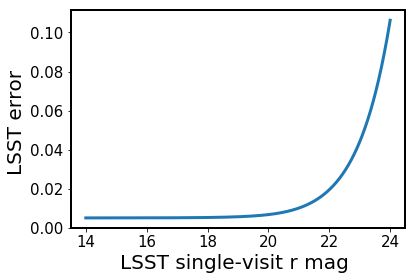

In [10]:
%matplotlib inline
def calc_lsst_error(m):
    # Calculate LSST error based on the magnitude of the observed light curve ...
    # we use magnitude-dependent single-visit 
    # formula for r-band from 
    # https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf
    # https://www.lsst.org/scientists/scibook
    # https://arxiv.org/abs/0912.0201
    # See Chap.3, Sec. 3.5, Eq. 3.1, Table. 3.2
     # mag 
    sigma_sys = 0.005
    gamma = 0.039 
    m5 = 24.7
    x = np.power(10,0.4 * (m-m5))
    sigma_rand = np.sqrt(  (0.04-gamma) * x + gamma * x*x ) 
    sigma = np.sqrt(sigma_sys**2.0 + sigma_rand**2.0)
    return sigma

# Illustrate 
# Plot the error curve 
m = np.linspace(14,24,1000)
e = calc_lsst_error(m)
plt.plot(m,e, lw=3)
plt.xlabel('LSST single-visit r mag ')
plt.ylabel('LSST error ')
plt.savefig('LSST_error_curve_rband.png', bbox_inches='tight')